In [38]:
import sklearn as skl
import sys
import numpy as np
import csv
import re
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

your_list= []
file1_1 = open("reviews.csv","r",encoding="utf8")
for line1_1 in file1_1: 
    your_list.append(line1_1[:-1])

file1_1.close()
your_list = your_list[1:]
#your_list = your_list[0:1000]
your_label   = []
your_comment = []
 
for i in your_list:
    your_label.append(i.split('|')[0])
    your_comment.append(i.split('|')[1:])

def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    return text
    
your_comment_1 = your_comment
   
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer()
docs  = np.array(your_comment_1)
bag   = count.fit_transform(docs.ravel())

from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)

your_sentiment = []

for i in your_label:
    if i=='positive': your_sentiment.append(1)
    else: your_sentiment.append(0)

x_train = np.asarray(your_comment_1[0:10000])
y_train = np.asarray(your_sentiment[0:10000])
x_test  = np.asarray(your_comment_1[320000:])
y_test  = np.asarray(your_sentiment[320000:])

from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

def tokenizer(text):
    text=str(text)
    return text.split()
def tokenizer_porter(text):
    text=str(text)
    return [porter.stem(word) for word in text.split()]

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nilkanth/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier




tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter]},
#               'clf__max_depth': [1, 5, 10]},
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__use_idf':[False],
               'vect__norm':[None]}
#               'clf__max_depth': [1, 5, 10]},
              ]
nn_tfidf = Pipeline([('vect', tfidf),
                     ('clf',  MLPClassifier(solver='lbfgs', 
                                            alpha=1e-5,
                                            hidden_layer_sizes=(10,10), 
                                            random_state=1))])


gs_nn_tfidf = GridSearchCV(nn_tfidf, 
                           param_grid, 
                           cv=5,
                           n_jobs=-1,
                           verbose=1)                        


In [17]:
gs_nn_tfidf.fit(x_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  18 out of  40 | elapsed:  2.4min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  5.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...      solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'vect__ngram_range': [(1, 1)], 'vect__stop_words': [['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's...8>, <function tokenizer_porter at 0x7fe23e1e20d0>], 'vect__use_idf': [False], 'vect__norm': [None]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
    

In [18]:
print('Best parameter set: %s ' % gs_nn_tfidf.best_params_)
print('CV Accuracy: %.3f' % gs_nn_tfidf.best_score_)

Best parameter set: {'vect__ngram_range': (1, 1), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer_porter at 0x7fe23e1e20d0>} 
CV Accuracy: 0.836


In [19]:
clf  =  gs_nn_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf.score(x_test, y_test))

Test Accuracy: 0.842


In [ ]:
len(x_test)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


train_sizes, train_scores, test_scores =\
                learning_curve(estimator=gs_nn_tfidf,
                               X=x_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('./figures/learning_curve.png', dpi=300)
plt.show()

In [32]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10, random_state=1).split(x_train, y_train)


scores = []
for k, (train, test) in enumerate(kfold):
    gs_nn_tfidf.fit(x_train[train], y_train[train])
    score = gs_nn_tfidf.score(x_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1,
          np.bincount(y_train[train]), score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))


TypeError: only integer scalar arrays can be converted to a scalar index

In [47]:
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(x_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[33447  6839]
 [ 7183 32531]]


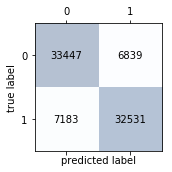

In [49]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
plt.savefig('confusion_matrix_NN.png', dpi=600)
plt.show()

In [50]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))


Precision: 0.826
Recall: 0.819
F1: 0.823


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  18 out of  40 | elapsed:  1.7min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  4.0min finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  18 out of  40 | elapsed:  1.9min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  4.3min finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  18 out of  40 | elapsed:  1.7min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  4.5min finished


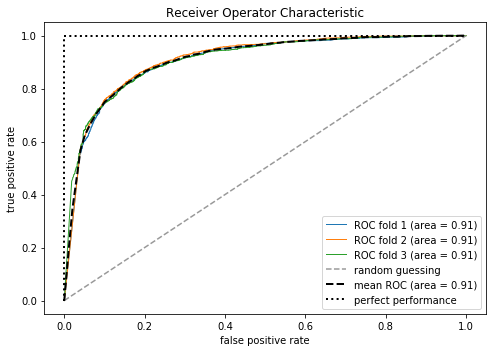

In [55]:
from sklearn.metrics import roc_curve, auc
from scipy import interp



X_train2 = x_train[0:20000]
cv = list(StratifiedKFold(n_splits=3, 
                              random_state=1).split(x_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = gs_nn_tfidf.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             lw=1,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         lw=2,
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")

plt.tight_layout()
# plt.savefig('./figures/roc.png', dpi=300)
plt.show()